In [1]:
import pickle

import arviz as az
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn.objects as so

from perelson1993abc import T_VALS, simulate_hiv

In [2]:
with open("perelson1993abc.pkl", "rb") as file_:
    idata_hiv = pickle.load(file_)

In [3]:
az.summary(idata_hiv)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
N,740.234,242.929,456.000,1103.000,85.640,62.898,8.0,8.0,52.88
s,0.410,0.295,0.038,0.942,0.104,0.076,8.0,8.0,22.08
mu_V,0.274,0.061,0.187,0.407,0.021,0.016,8.0,8.0,70.62


In [4]:
posterior = idata_hiv.posterior.stack(samples=('draw', 'chain'))
posterior

<xarray.Dataset>
Dimensions:  (samples: 16000)
Coordinates:
  * samples  (samples) object MultiIndex
  * draw     (samples) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999
  * chain    (samples) int64 0 1 2 3 4 5 6 7 0 1 2 3 ... 4 5 6 7 0 1 2 3 4 5 6 7
Data variables:
    N        (samples) int64 937 587 456 550 544 963 ... 550 544 1089 664 1103
    s        (samples) float64 0.7667 0.1165 0.3705 ... 0.4181 0.175 0.9425
    mu_V     (samples) float64 0.3087 0.2473 0.1875 ... 0.2887 0.2718 0.4072
Attributes:
    created_at:                 2023-06-21T22:31:38.116924
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

array([[<Axes: title={'center': 'N'}>, <Axes: title={'center': 's'}>],
       [<Axes: title={'center': 'mu_V'}>, <Axes: >]], dtype=object)

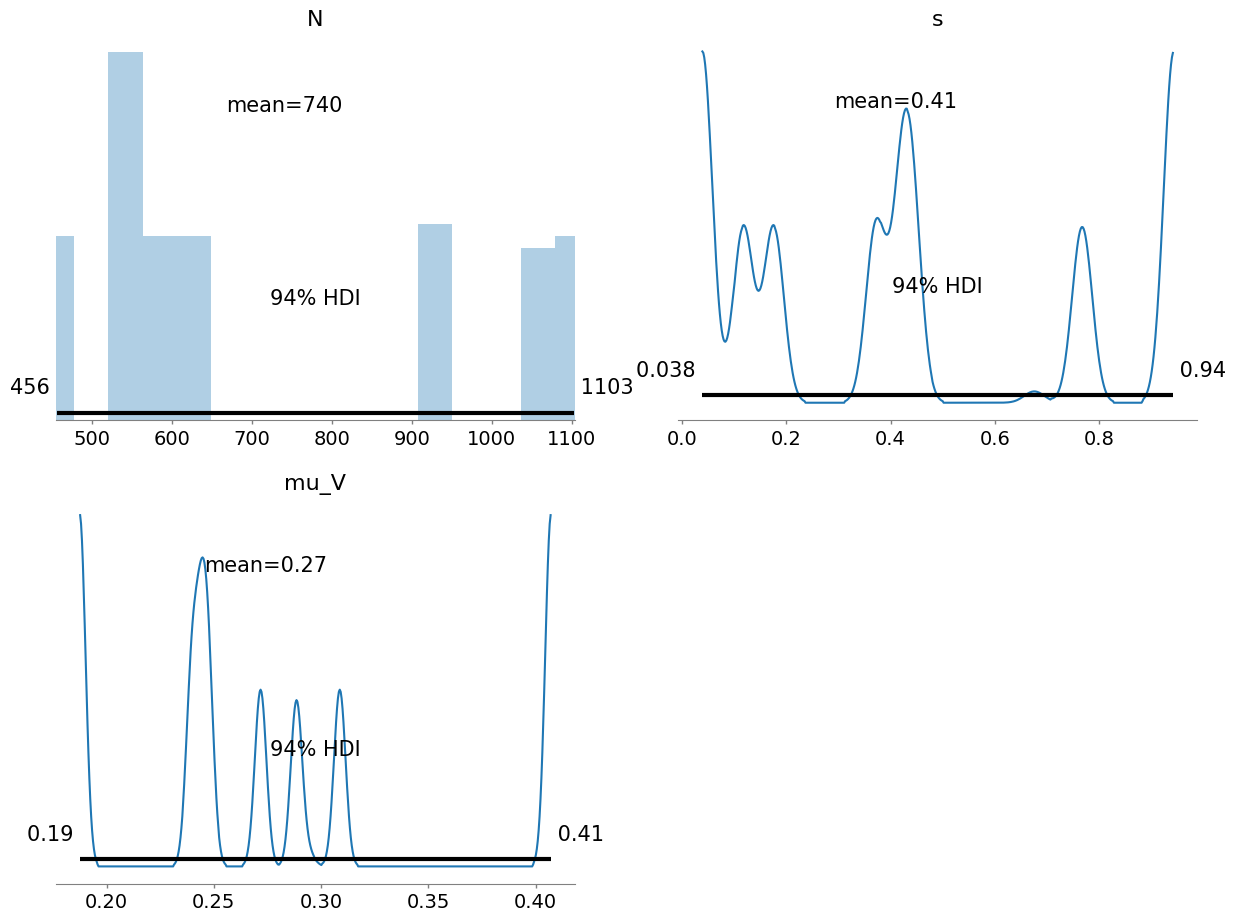

In [5]:
az.plot_posterior(idata_hiv, grid=(2, 2,))

array([[<Axes: ylabel='s'>, <Axes: >],
       [<Axes: xlabel='N', ylabel='mu_V'>, <Axes: xlabel='s'>]],
      dtype=object)

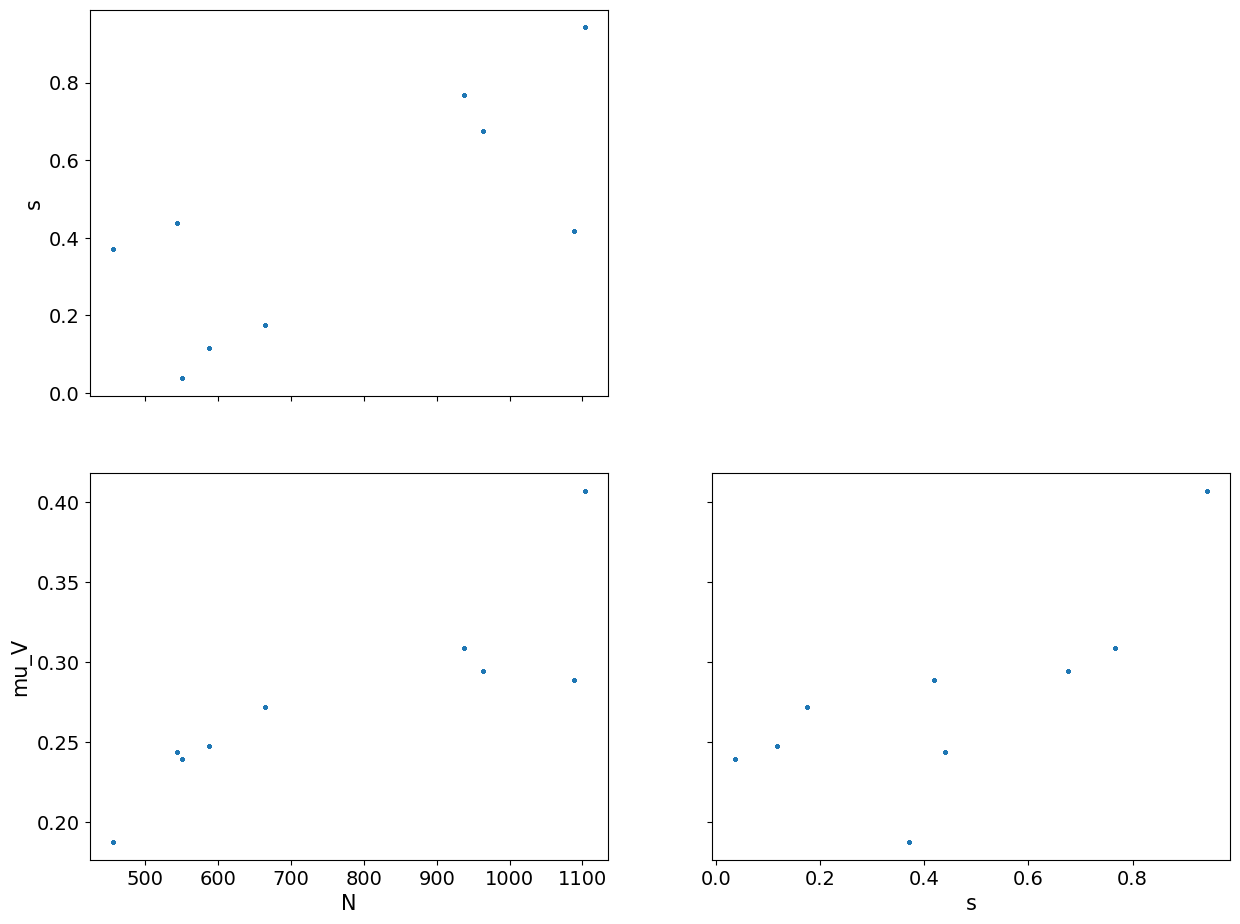

In [6]:
az.plot_pair(idata_hiv)

In [7]:
obs_var = [key for key in idata_hiv.observed_data.variables.keys()][-1]
obs_cd4 = idata_hiv.observed_data[obs_var]
obs_cd4

<xarray.DataArray 'sim' (sim_dim_0: 18)>
array([ 540.,  660.,  820.,  660.,  780.,  980.,  620.,  940.,  940.,
        700.,  580.,  940.,  980., 1060., 1020.,  820.,  940.,  820.])
Coordinates:
  * sim_dim_0  (sim_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

In [8]:
params = [key for key in idata_hiv.posterior.keys()]
params

['N', 's', 'mu_V']

In [9]:
num_samples=100
samples = az.extract(idata_hiv, num_samples=num_samples)
samples

<xarray.Dataset>
Dimensions:  (sample: 100)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 4 2 3 2 2 1 1 6 0 0 4 ... 6 5 5 4 1 0 3 0 6 3 5 7
  * draw     (sample) int64 1578 1327 1995 30 1318 104 ... 704 787 1933 558 199
Data variables:
    N        (sample) int64 937 544 456 550 456 456 ... 937 664 550 1089 1103
    s        (sample) float64 0.7667 0.4394 0.3705 ... 0.03776 0.4181 0.9425
    mu_V     (sample) float64 0.3087 0.2438 0.1875 ... 0.2397 0.2887 0.4072
Attributes:
    created_at:                 2023-06-21T22:31:38.116924
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

In [10]:
df = samples.to_dataframe()
df.drop(columns=df.columns[[-2, -1]], inplace=True)
df["cd4"] = df.apply(lambda x: simulate_hiv(None, *x), axis=1)
df = df.explode("cd4")
df["cd4"] = pd.to_numeric(df["cd4"])
df["day"] = np.tile(T_VALS, num_samples)
# seaborn's object interface can't use the intersection of 2 groups yet.
df["sample"] = df.groupby(["chain", "draw"]).ngroup()
# seaborn plotting runs extremely slowly if multi-indexing is active.
df = df.reset_index()
df

,chain,draw,N,s,mu_V,cd4,day,sample
0,0,1578,937,0.766729,0.308713,7099.270034,2007.5,10
1,0,1578,937,0.766729,0.308713,7099.270034,2190.0,10
2,0,1578,937,0.766729,0.308713,7099.270034,2372.5,10
3,0,1578,937,0.766729,0.308713,7099.270034,2555.0,10
4,0,1578,937,0.766729,0.308713,7099.270034,2737.5,10
...,...,...,...,...,...,...,...,...
1795,7,199,1103,0.942494,0.407216,7680.511423,4380.0,93
1796,7,199,1103,0.942494,0.407216,7680.511423,4562.5,93
1797,7,199,1103,0.942494,0.407216,7680.511423,4745.0,93
1798,7,199,1103,0.942494,0.407216,7680.511423,5110.0,93


In [11]:
df.describe()

,chain,draw,N,s,mu_V,cd4,day,sample
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.990000,994.400000,722.380000,0.396813,0.265308,6183.595265,3583.083333,49.500000
std,2.161596,588.687157,243.119791,0.281306,0.056656,987.161900,979.537648,28.874092
min,0.000000,30.000000,456.000000,0.037757,0.187463,5031.474668,2007.500000,0.000000
25%,1.000000,513.750000,544.000000,0.116495,0.239666,5471.350400,2737.500000,24.750000
50%,3.000000,979.500000,587.000000,0.370478,0.247319,5673.329236,3595.250000,49.500000
75%,5.000000,1436.000000,937.000000,0.439433,0.288663,7099.270034,4380.000000,74.250000
max,7.000000,1995.000000,1103.000000,0.942494,0.407216,7680.511423,5292.500000,99.000000


In [12]:
# Encapsulate observed data and row-bind it to the simulations for plotting.
df_data = pd.DataFrame({"cd4": obs_cd4, "day": T_VALS, "sample": num_samples, "type": "observed"})
df_data

,cd4,day,sample,type
0,540.0,2007.5,100,observed
1,660.0,2190.0,100,observed
2,820.0,2372.5,100,observed
3,660.0,2555.0,100,observed
4,780.0,2737.5,100,observed
5,980.0,2920.0,100,observed
6,620.0,3102.5,100,observed
7,940.0,3285.0,100,observed
8,940.0,3504.0,100,observed
9,700.0,3686.5,100,observed


In [13]:
df["type"] = "simulated"
df_both = pd.concat([df_data, df]).reset_index()
df_both

,index,cd4,day,sample,type,chain,draw,N,s,mu_V
0,0,540.000000,2007.5,100,observed,NaN,NaN,NaN,NaN,NaN
1,1,660.000000,2190.0,100,observed,NaN,NaN,NaN,NaN,NaN
2,2,820.000000,2372.5,100,observed,NaN,NaN,NaN,NaN,NaN
3,3,660.000000,2555.0,100,observed,NaN,NaN,NaN,NaN,NaN
4,4,780.000000,2737.5,100,observed,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1813,1795,7680.511423,4380.0,93,simulated,7.0,199.0,1103.0,0.942494,0.407216
1814,1796,7680.511423,4562.5,93,simulated,7.0,199.0,1103.0,0.942494,0.407216
1815,1797,7680.511423,4745.0,93,simulated,7.0,199.0,1103.0,0.942494,0.407216
1816,1798,7680.511423,5110.0,93,simulated,7.0,199.0,1103.0,0.942494,0.407216


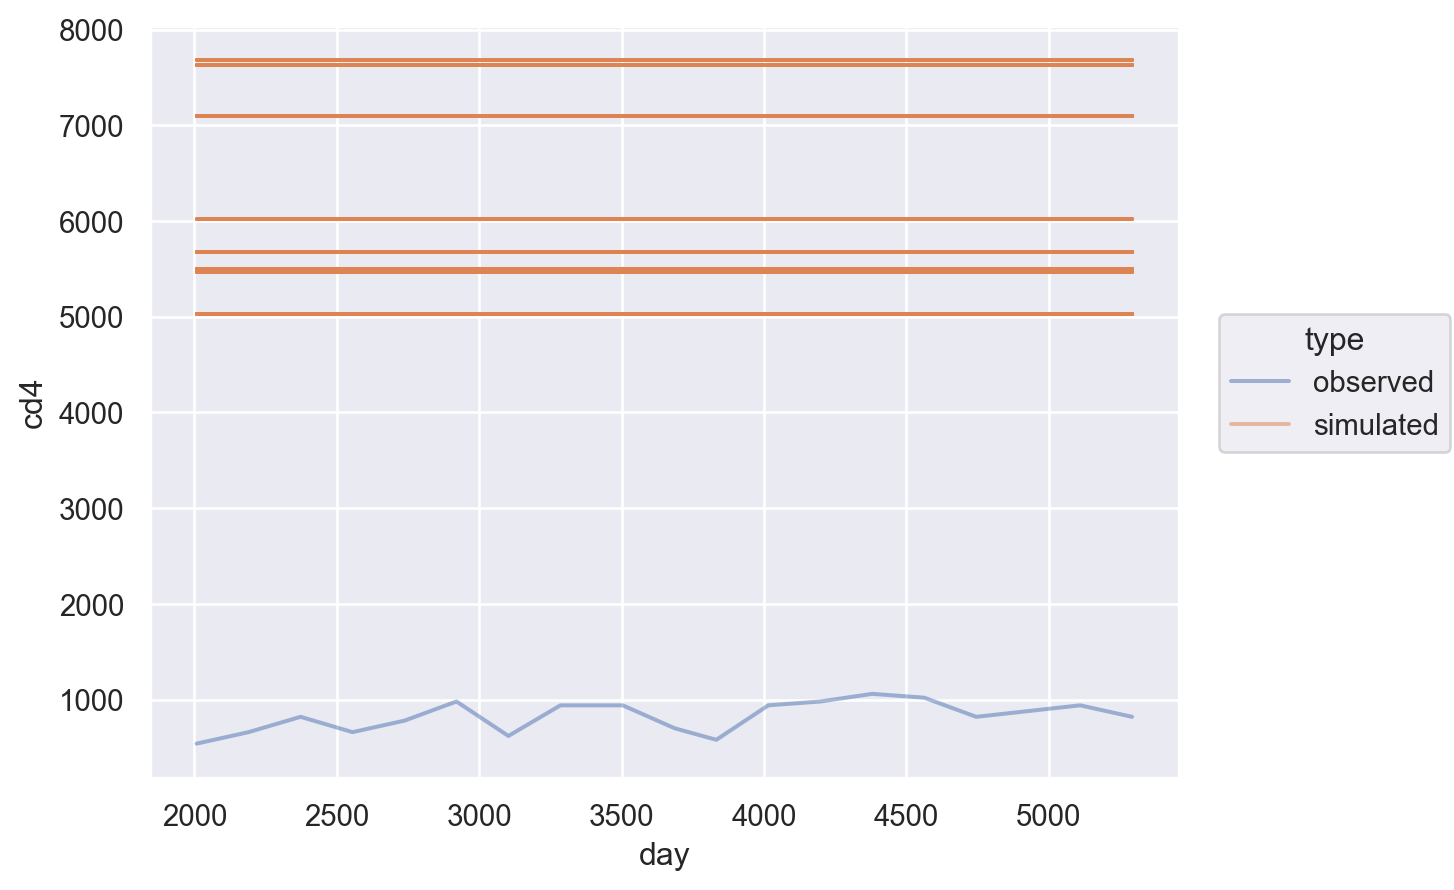

In [14]:
(
    so.Plot(df_both, x="day", y="cd4", group="sample", color = "type")
    .add(so.Line(alpha = .5))
    #.scale(y="log")
)